## Simulate recombination to generate expected fragment length distribution

### (not ready yet)

We want an expectation for the proportion of fragments that will be big vs medium vs small as a function of number of generations.

### imports

In [173]:
import numpy as np
from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### starter simulations

In [4]:
chrom_len = 1e9
rec_rate = 1e-8

### do we have to model each generation, or can we just calculate the number of "total crossovers" based on the number of generations and an average rate?

here's the "mechanistic" version where we simulate at least one crossover per generation, but averaging around 1.2 per generation (by adding a random poisson of .2)

In [97]:
num_gens = 1000

num_trials = 10000
trial_list = np.zeros((num_trials),dtype= np.int64)
for trial in range(num_trials):
    cr_arr = np.zeros((num_gens),dtype = np.int8)
    for i in range(num_gens):
            cr_arr[i] = 1+np.random.poisson(.2)

    trial_list[trial] = np.sum(cr_arr)

In [101]:
np.mean(trial_list)

1200.1711

In [102]:
np.var(trial_list)

204.39662478999998

Here's a totally not mechanistic version -- just doing a random poisson around the expected number of crossovers given an average of 1.2 per generation.

In [98]:
trial_list2 = np.zeros((num_trials),dtype= np.int64)
for trial in range(num_trials):
    trial_list2[trial] = np.random.poisson(1.2*1000)

In [99]:
np.mean(trial_list2)

1199.9317

In [100]:
np.var(trial_list2)

1193.48443511

We see that the variance is much too high, because we don't force it to have at least one per generation. The real "poisson" is in the average .2 over the required one.

So now let's try saying that there will be one per generation, then we *expect* an additional .2 per generation, using the total number of gens.

In [104]:
trial_list3 = np.zeros((num_trials),dtype= np.int64)
for trial in range(num_trials):
    trial_list3[trial] = num_gens + np.random.poisson(num_gens*.2)

In [105]:
np.mean(trial_list3)

1199.8931

In [106]:
np.var(trial_list3)

201.23847239

Great, this perfectly matches our "mechanistic" version.

### function for getting number of crossovers given the average per generation and the number of generations.

In [115]:
@jit
def get_num_crossovers(num_gens,
                      avg_per_gen = 1.2,
                      require1 = True):
    if require1:
        return(num_gens + np.random.poisson(num_gens*(avg_per_gen-1)))
    else:
        return(np.random.poisson(num_gens*(avg_per_gen)))


In [116]:
@jit
def get_num_crossovers1(num_gens,
                      avg_per_gen = 1.2):
    return(num_gens + np.random.poisson(num_gens*(avg_per_gen-1)))

In [119]:
%%timeit
get_num_crossovers(1000)

The slowest run took 4.18 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 47.9 µs per loop


In [120]:
%%timeit
get_num_crossovers1(1000)

The slowest run took 4.58 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 39.1 µs per loop


### now, check out the distribution of fragment lengths per number of generations given a uniform distribution of recomb locations

In [202]:
@jit
def get_breaks(num_gens,chrom_len):
    return(np.hstack([np.array([0],dtype=np.int64),np.sort(np.random.randint(chrom_len,size=get_num_crossovers1(num_gens))),np.array([chrom_len],dtype = np.int64)]))

In [203]:
@jit
def get_dists(breaks):
    num = len(breaks)
    distarr = np.zeros((num-1),dtype=np.int64)
    for i in range(num-1):
        distarr[i]=breaks[i+1]-breaks[i]
    return(distarr)

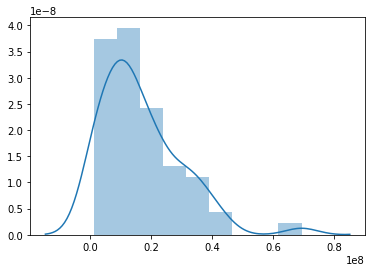

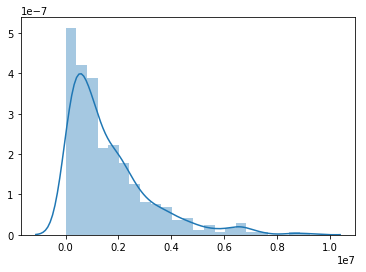

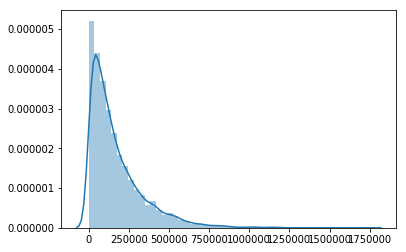

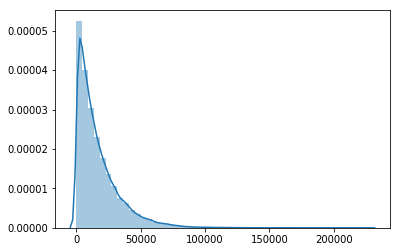

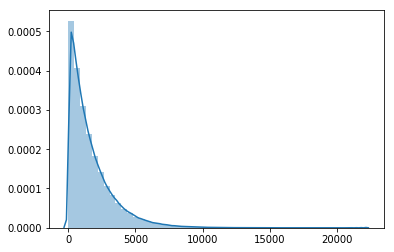

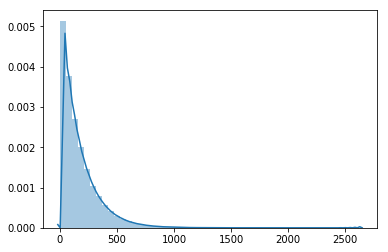

In [206]:
sns.distplot((get_dists(get_breaks(50,chrom_len=chrom_len))))
plt.show()
sns.distplot((get_dists(get_breaks(500,chrom_len=chrom_len))))
plt.show()
sns.distplot((get_dists(get_breaks(5000,chrom_len=chrom_len))))
plt.show()
sns.distplot((get_dists(get_breaks(50000,chrom_len=chrom_len))))
plt.show()
sns.distplot((get_dists(get_breaks(500000,chrom_len=chrom_len))))
plt.show()
sns.distplot((get_dists(get_breaks(5000000,chrom_len=chrom_len))))
plt.show()

In [207]:
fragment_lengths = get_dists(get_breaks(5000,chrom_len=chrom_len))

kernel_est = stats.gaussian_kde(fragment_lengths,bw_method=1e-3)

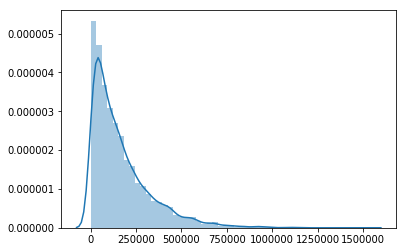

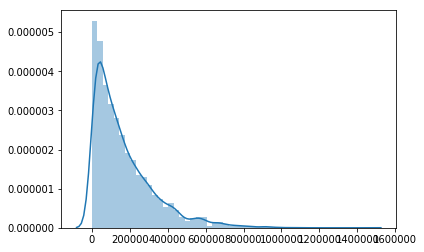

In [214]:
sns.distplot(fragment_lengths)
plt.show()
sns.distplot(kernel_est.resample(5000))
plt.show()